In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import MaxPooling2D , GlobalAveragePooling2D,Conv2D , BatchNormalization , Flatten , Dropout , Activation , Input ,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG , Image
from tensorflow.keras.optimizers import Adam

In [3]:
from glob import glob
import cv2
import random

In [4]:
import matplotlib.pyplot as plt

# TRAIN IMAGES DISPLAY

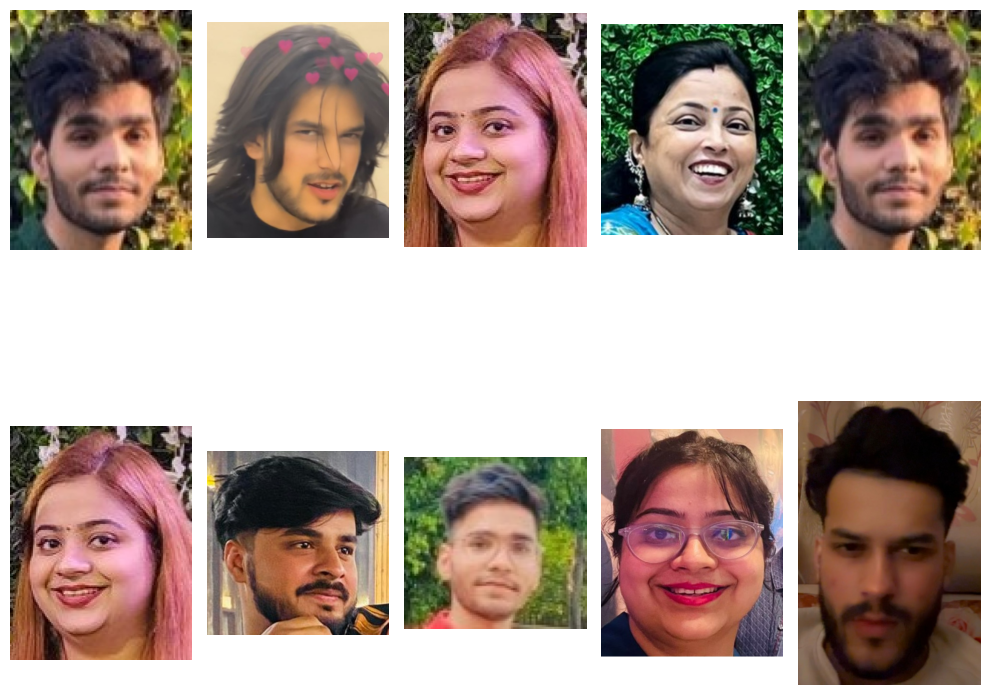

In [5]:
train_images = glob("Attendance/TRAIN/**/**")
plt.figure(figsize = (10 , 10))
for i in range(10):
    image = random.choice(train_images)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

    plt.subplot(2 , 5 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# TEST IMAGES DISPLAY

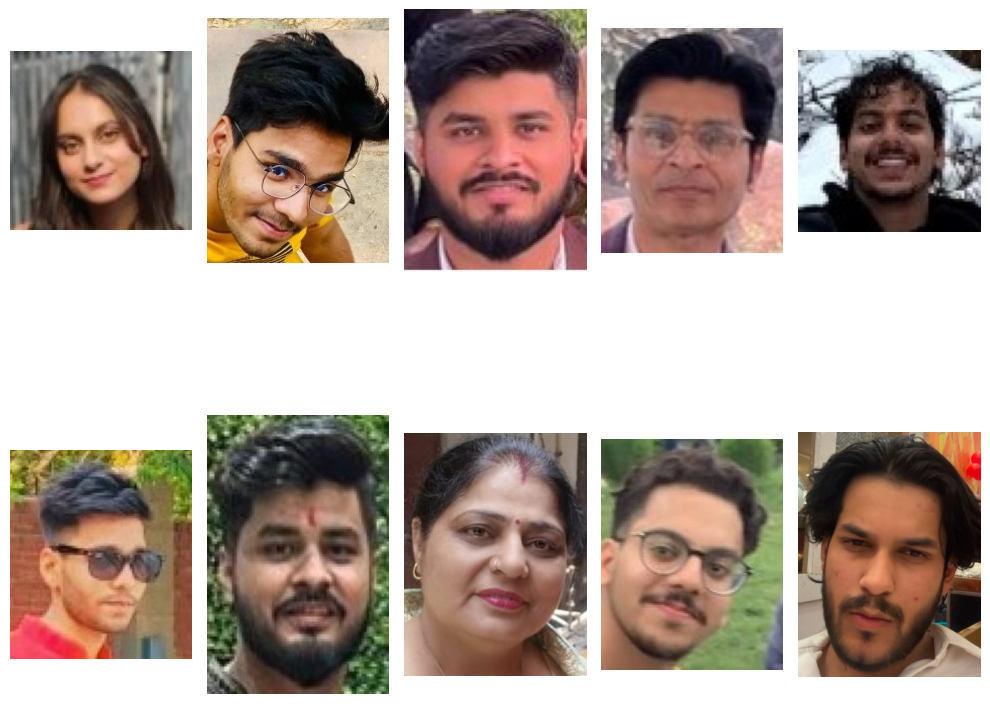

In [6]:
val_images = glob("Attendance/TEST/**/**")
plt.figure(figsize = (10,10))
for i in range(10):
    image = random.choice(val_images)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    plt.subplot(2 , 5 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Data Augmentation

In [7]:
img_size = 128
batch_size = 16
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest'
)
train_set = datagen.flow_from_directory(
    "Attendance/TRAIN/",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)
print("Classes Found (Training):", train_set.class_indices)

datagen_test = ImageDataGenerator(rescale=1./255)
test_set = datagen_test.flow_from_directory(
    "Attendance/TEST/",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)
print("Classes Found (Testing):", test_set.class_indices)

Found 100 images belonging to 10 classes.
Classes Found (Training): {'201': 0, '202': 1, '203': 2, '204': 3, '205': 4, '206': 5, '207': 6, '208': 7, '209': 8, '210': 9}
Found 100 images belonging to 10 classes.
Classes Found (Testing): {'201': 0, '202': 1, '203': 2, '204': 3, '205': 4, '206': 5, '207': 6, '208': 7, '209': 8, '210': 9}


In [8]:
labels = train_set.class_indices
print("Student Labels:", labels)

Student Labels: {'201': 0, '202': 1, '203': 2, '204': 3, '205': 4, '206': 5, '207': 6, '208': 7, '209': 8, '210': 9}


# CNN MODEL

In [9]:
def build_model(input_shape):
    input_layer = Input(shape=input_shape)

    #x = Conv2D(32, (3,3), padding='same', activation='relu')(input_layer)
    #x = BatchNormalization()(x)
    #x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), padding='same' , activation = 'relu')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), padding='same' , activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256 , (3,3) , padding = 'same' , activation = 'relu', kernel_regularizer = l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)

    output = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
model = build_model((img_size , img_size , 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,932,682 (129.44 MB)

 Trainable params: 33,931,786 (129.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# MODEL CHECKPOINT

In [13]:
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
epochs = 100
history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr],
                    verbose=1)

C:\Users\user\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1290 - loss: 10.7064

C:\Users\user\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1304 - loss: 11.0528 - val_accuracy: 0.1000 - val_loss: 3.5690 - learning_rate: 3.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1313 - loss: 12.8371 - val_accuracy: 0.1300 - val_loss: 3.7710 - learning_rate: 3.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2184 - loss: 11.3927 - val_accuracy: 0.1000 - val_loss: 5.4490 - learning_rate: 3.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3220 - loss: 8.1682 - val_accuracy: 0.1000 - val_loss: 7.1873 - learning_rate: 3.0000e-04
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2961 - loss: 9.8426 - val_accuracy: 0.0900 - val_loss: 9.0124 - learning_rate: 1.5000e-04
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4362 - loss: 5.5655 - val_accuracy: 0.0900 - val_loss: 10.8839 - learning_rate: 1.5000e-04
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3507 - loss: 7.4809 - val_a

# Model Accuracy

In [14]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.6264 - loss: 3.0124


In [15]:
test_accuracy*100

62.00000047683716

In [ ]:
import pickle

In [16]:
model.save("upg_student_face_recognition.h5")

In [ ]:
with open("labels.pkl", "wb") as f:
    pickle.dump(labels, f)